# Superpixel learning


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = set_device(verbose=True)

cuda available


# MNIST Superpixel 

In [2]:
from superpixels import SuperPixDataset
DATASET_NAME = 'MNIST'
dataset = SuperPixDataset(DATASET_NAME)  # 54s
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] Loading dataset MNIST...
<_io.BufferedReader name='../Datasets/superpixels/MNIST.pkl'>
train, test, val sizes : 55000 10000 5000
[I] Finished loading.
[I] Data load time: 41.2780s


## Visualise the dataset

Label: tensor(0)
graph: DGLGraph(num_nodes=72, num_edges=576,
         ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float16)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float16)})
Largest eigenvalue: 1.4082603442423633
Smallest eigenvalue: 2.7755575615628914e-17


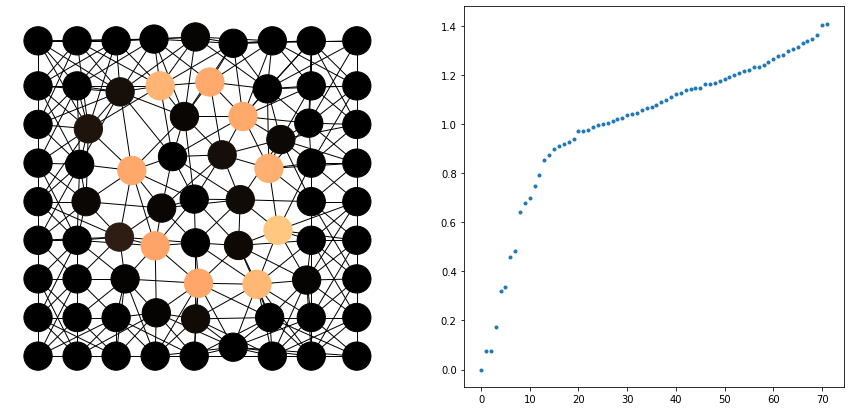

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(45000)]
nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=g_demo.ndata['feat'][:,0],
        pos = g_demo.ndata['feat'][:,1:3].numpy(),
        node_size=800,
        cmap='copper' )

print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


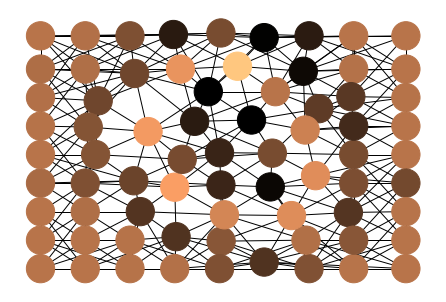

In [4]:
from utils import chebyshev
from laplacian import normalized_laplacian
L = normalized_laplacian(g_demo).to_dense()
Fmap = chebyshev(L,g_demo.ndata['feat'][:,0:3].float() ,3)

nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=Fmap[1][:,0],
        node_size=800,
        pos = g_demo.ndata['feat'][:,1:3].numpy(),
        cmap='copper')

# Model definition for training

In [5]:
from model import DGL_mean_Classifier, Classifier
# model_parameters
in_features = 3
first_conv_out = 64
second_conv_out = 64
hidden_layer_classifier = 128
k = 4
n_classes = 10

net = DGL_mean_Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k, readout="max"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=3, out_features=64, bias=False)
        (1): Linear(in_features=3, out_features=64, bias=False)
        (2): Linear(in_features=3, out_features=64, bias=False)
        (3): Linear(in_features=3, out_features=64, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=False)
        (1): Linear(in_features=64, out_features=64, bias=False)
        (2): Linear(in_features=64, out_features=64, bias=False)
        (3): Linear(in_features=64, out_features=64, bias=False)
      )
    )
    (2): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=False)
        (1): Linear(in_features=64, out_features=64, bias=False)
        (2): Linear(in_features=64, out_features=64, bias=False)
        (3): Linear(in_features=64, out_features=64, bias=False)
      )
    )
    (3):

In [6]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_max_superpix'))

# Training pipe

In [7]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=2048,
                         shuffle=True, collate_fn=collate2, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=1000,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=1000,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=True)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

epoch_losses = []

, (torch.ones(2048)*1.4).to(device)

In [8]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (bGraph, label) in enumerate(data_loader):
            bGraph, label = bGraph.to(device), label.to(device)
            
            #lmax = normalized_laplacian(bGraph)
            #print(lmax)
            output = model(bGraph, 
                           bGraph.ndata['feat'].float().to(device), (torch.ones(2048)*1.4).to(device) )
            loss = loss_func(output, label.to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {}, loss - train {:.4f} - val {:.4f} -- Accuracy: {}/{} ({:.0f}%) in {:.2f}(s) ".format(
                epoch, epoch_loss, val_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [9]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = model(Bgraph, Bgraph.ndata['feat'].float(), (torch.ones(1000)*1.4).to(device))
            # sum up batch loss
            test_loss += loss_func(output, label.to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [10]:
train(net, device, train_loader, 30, loss_func,optimizer, scheduler)

Epoch 0, loss - train 3.5781 - val 2.3612 -- Accuracy: 6007/55000 (11%) in 19.44(s) 
Epoch 1, loss - train 2.2388 - val 2.1266 -- Accuracy: 10526/55000 (19%) in 18.42(s) 
Epoch 2, loss - train 2.0639 - val 2.0006 -- Accuracy: 13849/55000 (25%) in 18.55(s) 
Epoch 3, loss - train 1.9486 - val 1.8921 -- Accuracy: 16240/55000 (30%) in 18.82(s) 
Epoch 4, loss - train 1.8382 - val 1.7834 -- Accuracy: 18678/55000 (34%) in 19.10(s) 
Epoch 5, loss - train 1.7270 - val 1.6693 -- Accuracy: 21332/55000 (39%) in 18.19(s) 
Epoch 6, loss - train 1.5939 - val 1.5103 -- Accuracy: 24435/55000 (44%) in 18.68(s) 
Epoch 7, loss - train 1.4534 - val 1.3683 -- Accuracy: 27131/55000 (49%) in 18.85(s) 
Epoch 8, loss - train 1.3345 - val 1.2652 -- Accuracy: 29333/55000 (53%) in 18.77(s) 
Epoch 9, loss - train 1.2331 - val 1.1658 -- Accuracy: 31135/55000 (57%) in 18.99(s) 
Epoch 10, loss - train 1.1510 - val 1.1081 -- Accuracy: 32786/55000 (60%) in 21.26(s) 
Epoch 11, loss - train 1.0855 - val 1.0340 -- Accuracy

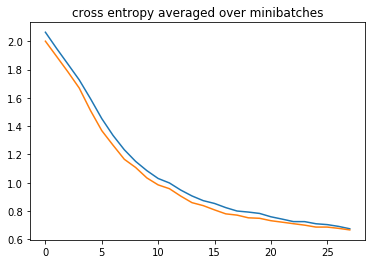

In [11]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses[2:])

plt.show()

In [12]:
torch.cuda.empty_cache()

## Test Metrics

In [13]:
test(net,device,test_loader)


 Average loss per epoch: 0.6683, Accuracy: 7905/10000 (79%)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       980
           1       0.86      0.96      0.91      1135
           2       0.85      0.74      0.79      1032
           3       0.76      0.80      0.78      1010
           4       0.71      0.77      0.74       982
           5       0.68      0.70      0.69       892
           6       0.77      0.89      0.82       958
           7       0.91      0.74      0.81      1028
           8       0.78      0.68      0.73       974
           9       0.70      0.71      0.71      1009

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [14]:
net.eval()
net(g_demo.to(device), g_demo.ndata['feat'].float().to(device), (torch.ones(1)*1.4).to(device))

tensor([ 3.7221, -7.1355,  0.2679, -3.7719, -1.9197, -1.0994, -0.9186, -4.3783,
        -3.0708, -3.6181], device='cuda:0', grad_fn=<AddBackward0>)

## Saving

In [15]:
from utils import save_model

save_model("Cheb_max_superpix", net)